In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
import os
import random
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Add, Dense, Activation, BatchNormalization, Conv2D
from keras.utils import np_utils
from keras.initializers import glorot_uniform
%matplotlib inline


In [ ]:
!mkdir ../data
!wget -O ../data/fer2013.csv https://www.dropbox.com/s/zi48lkarsg4kbry/fer2013.csv\?dl\=1

mkdir: cannot create directory ‘../data’: File exists
--2022-10-23 12:21:54--  https://www.dropbox.com/s/zi48lkarsg4kbry/fer2013.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/zi48lkarsg4kbry/fer2013.csv [following]
--2022-10-23 12:21:55--  https://www.dropbox.com/s/dl/zi48lkarsg4kbry/fer2013.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc34a34541dd8264074bf87e625a.dl.dropboxusercontent.com/cd/0/get/BvX57h41HilVkv30bs0vrgjUG0QzY3MOin7yE4ksxWjNKlopuT6qhsazMsHsunS5WLndFvDcNYt3oRJLrbucn9Y3Ad7tjSbPcdziWdY5PkVmQwmjIUY1k2XqtmoawhdAjs3j4yJ_PNXQD5WFKT2jKh7ce_xGgt-adod0D-f7P91GUQ/file?dl=1# [following]
--2022-10-23 12:21:55--  https://uc34a34541dd8264074bf87e625a.dl.dropboxusercontent.com/cd/0/get/BvX57h41HilVkv30bs0vrgjU

In [ ]:
num_classes=2
input_shape=(48,48,1)
model_name = "fer2013"
model_type = "fer2013"
epochs = 200
lrate = 0.01
decay = lrate/epochs
batch_size = 32


In [ ]:

def load_dataset(net=True):
    """Utility function to load the FER2013 dataset.
    
    It returns the formated tuples (X_train, y_train) , (X_test, y_test).

    Parameters
    ==========
    net : boolean
        This parameter is used to reshape the data from images in 
        (cols, rows, channels) format. In case that it is False, a standard
        format (cols, rows) is used.
    """

    # Load and filter in Training/not Training data:
    df = pd.read_csv('../data/fer2013.csv')
    training = df.loc[df['Usage'] == 'Training']
    testing = df.loc[df['Usage'] != 'Training']

    # X_train values:
    X_train = training[['pixels']].values
    X_train = [np.fromstring(e[0], dtype=int, sep=' ') for e in X_train]
    if net:
        X_train = [e.reshape((48, 48, 1)).astype('float32') for e in X_train]
    else:
        X_train = [e.reshape((48, 48)) for e in X_train]
    X_train = np.array(X_train)

    # X_test values:
    X_test = testing[['pixels']].values
    X_test = [np.fromstring(e[0], dtype=int, sep=' ') for e in X_test]
    if net:
        X_test = [e.reshape((48, 48, 1)).astype('float32') for e in X_test]
    else:
        X_test = [e.reshape((48, 48)) for e in X_test]
    X_test = np.array(X_test)

    # y_train values:
    y_train = training[['emotion']].values
    # y_train = keras.utils.to_categorical(y_train)

    # y_test values
    y_test = testing[['emotion']].values
    # y_test = keras.utils.to_categorical(y_test)

    return (X_train, y_train) , (X_test, y_test)

In [ ]:
(X_train, y_train) , (X_test, y_test) = load_dataset()
print(y_train.shape, y_test.shape)
print(X_train.shape, X_test.shape)

(28709, 1) (7178, 1)
(28709, 48, 48, 1) (7178, 48, 48, 1)


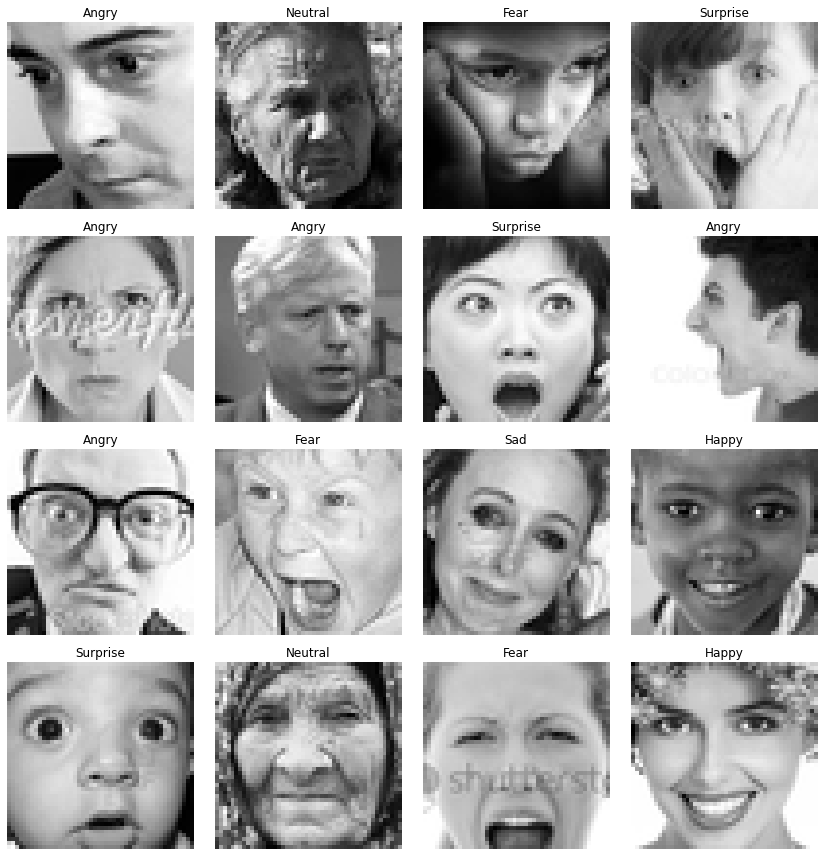

In [ ]:
class_names=["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]
plt.style.use('ggplot')

plt.figure(figsize=(12, 12))
for i in range(16):
    j = random.randint(0,28709) 
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_train[j].reshape((48, 48)), cmap="gray")
    plt.title("{}".format(class_names[y_train[j][0]]), fontsize=12)
    plt.axis('off')
    plt.tight_layout()


In [ ]:
class_3_index = np.where(y_train.reshape(-1) == 3)
X_train_class_3 = X_train[class_3_index]
y_train_class_3 = y_train[class_3_index]



class_4_index = np.where(y_train.reshape(-1) == 4)
X_train_class_4 = X_train[class_4_index]
y_train_class_4 = y_train[class_4_index]



X_train = np.concatenate((X_train_class_3, X_train_class_4))
y_train = np.concatenate((y_train_class_3, y_train_class_4)).reshape(-1,1)

# ---------------------------------------------------------------------------

class_3_index = np.where(y_test.reshape(-1) == 3)
X_test_class_3 = X_test[class_3_index]
y_test_class_3 = y_test[class_3_index]

class_4_index = np.where(y_test.reshape(-1) == 4)
X_test_class_4 = X_test[class_4_index]
y_test_class_4 = y_test[class_4_index]


X_test = np.concatenate((X_test_class_3, X_test_class_4))
y_test = np.concatenate((y_test_class_3, y_test_class_4)).reshape(-1,1)


print(y_train.shape, y_test.shape)
print(X_train.shape, X_test.shape)


(12045, 1) (3021, 1)
(12045, 48, 48, 1) (3021, 48, 48, 1)


__________________train_____________________


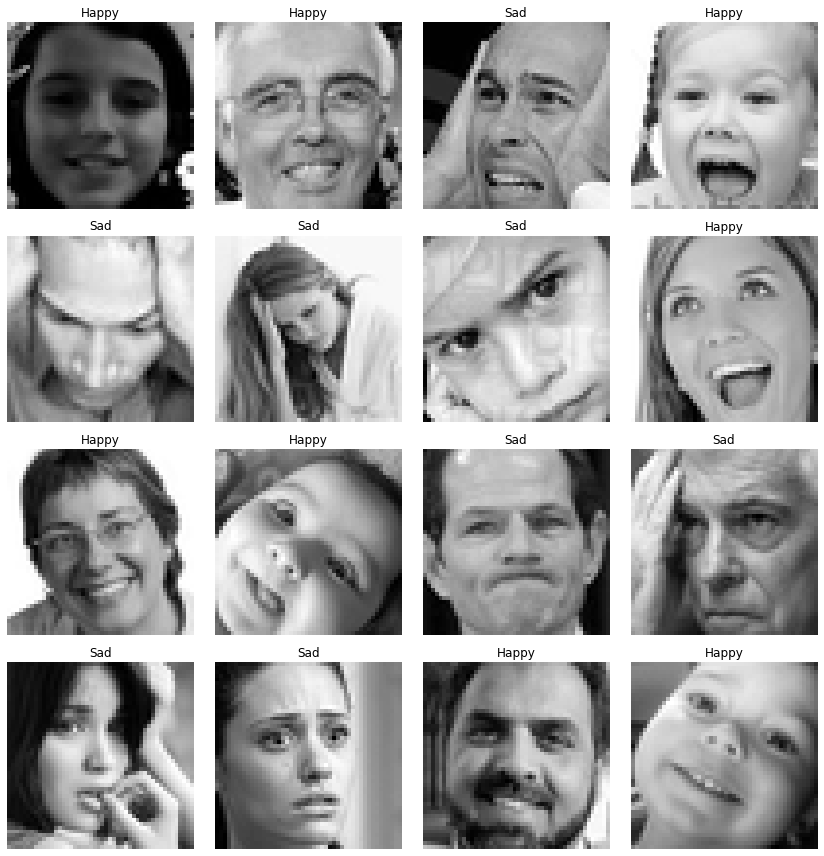

In [ ]:
print("__________________train_____________________")
plt.figure(figsize=(12, 12))
for i in range(16):
    j = random.randint(0,12045) 
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_train[j].reshape((48, 48)), cmap="gray")
    plt.title("{}".format(class_names[y_train[j][0]]), fontsize=12)
    plt.axis('off')
    plt.tight_layout()


___________________________________test___________________________


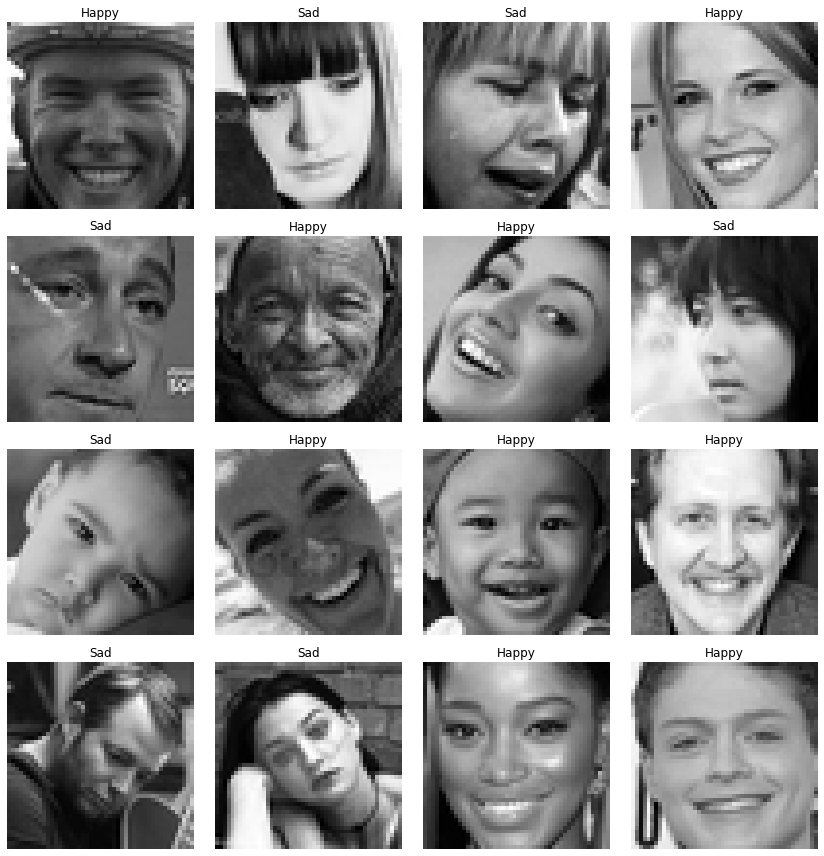

In [ ]:
print("___________________________________test___________________________")
plt.figure(figsize=(12, 12))
for i in range(16):
    j = random.randint(0,3021) 
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_test[j].reshape((48, 48)), cmap="gray")
    plt.title("{}".format(class_names[y_test[j][0]]), fontsize=12)
    plt.axis('off')
    plt.tight_layout()

In [ ]:
y_train = np.where(y_train > 3, 1, 0)
y_test = np.where(y_test > 3, 1, 0)
class_names = ['Happy',  'Sad']

print(y_train.shape, y_test.shape)

(12045, 1) (3021, 1)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X = np.concatenate((X_test, X_train))
Y = np.concatenate((y_test, y_train)).reshape(-1,1)

# X, y = shuffle(X, Y, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15)

print(y_train.shape, y_test.shape)
print(X_train.shape, X_test.shape)



(12806, 1) (2260, 1)
(12806, 48, 48, 1) (2260, 48, 48, 1)


__________________train_____________________


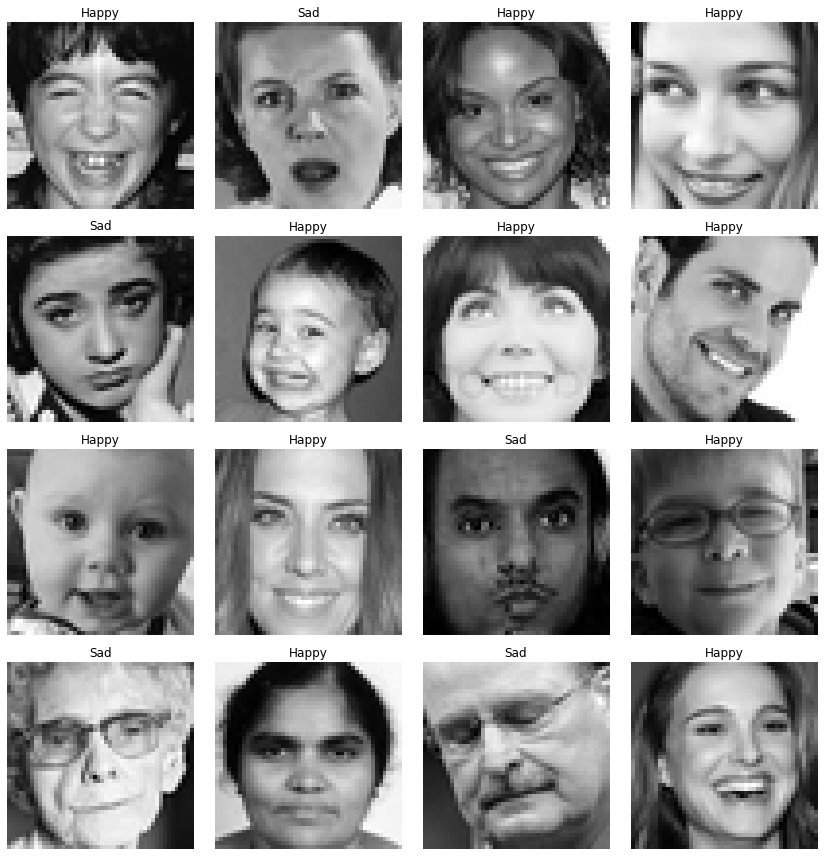

In [ ]:

print("__________________train_____________________")
plt.figure(figsize=(12, 12))
for i in range(16):
    j = random.randint(0,12806) 
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_train[j].reshape((48, 48)), cmap="gray")
    plt.title("{}".format(class_names[y_train[j][0]]), fontsize=12)
    plt.axis('off')
    plt.tight_layout()


___________________________________test___________________________


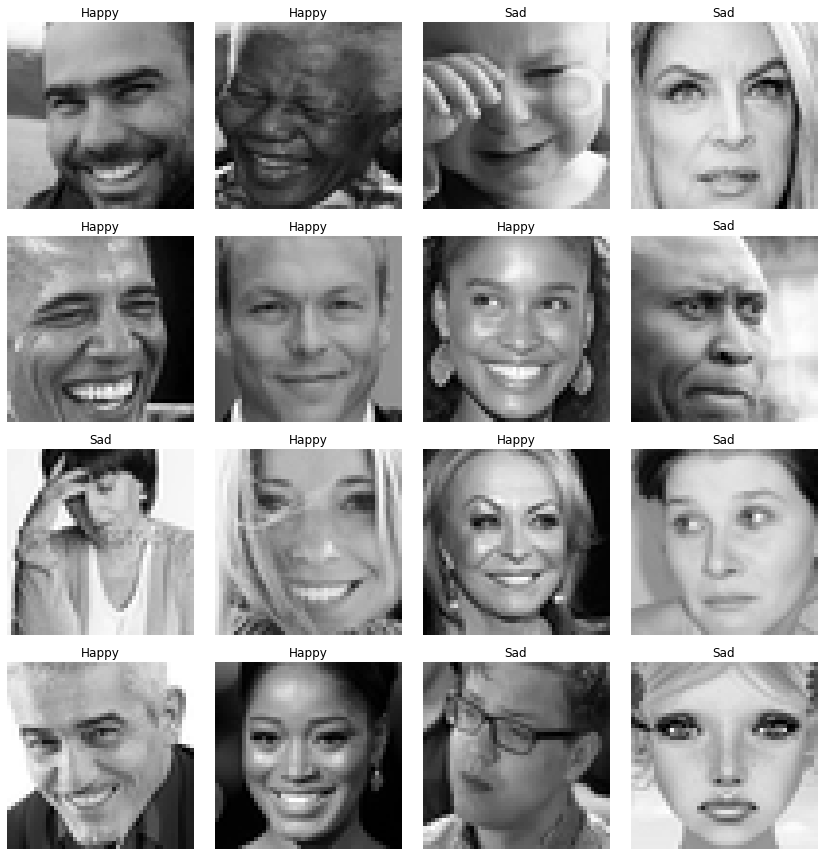

In [ ]:
print("___________________________________test___________________________")
plt.figure(figsize=(12, 12))
for i in range(16):
    j = random.randint(0,2260) 
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_test[j].reshape((48, 48)), cmap="gray")
    plt.title("{}".format(class_names[y_test[j][0]]), fontsize=12)
    plt.axis('off')
    plt.tight_layout()

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.
X_test = X_test / 255.

X_train_mean = np.mean(X_train)
X_train -= X_train_mean
X_test_mean = np.mean(X_test)
X_test -= X_test_mean

y_train = np_utils.to_categorical(y_train,)
y_test = np_utils.to_categorical(y_test,)
y_train = np.delete(y_train,1,1)
y_test = np.delete(y_test,1,1)

print(y_train.shape, y_test.shape)
print(X_train.shape, X_test.shape)

(12806, 1) (2260, 1)
(12806, 48, 48, 1) (2260, 48, 48, 1)


In [ ]:
# print("__________________train_____________________")
# plt.figure(figsize=(12, 12))
# for i in range(16):
#     j = random.randint(0,12045) 
#     plt.subplot(4, 4, i + 1)
#     plt.imshow(X_train[j].reshape((48, 48)), cmap="gray")
#     plt.title("{}".format(class_names[int(y_train[j])]), fontsize=12)
#     plt.axis('off')
#     plt.tight_layout()

In [ ]:
# print("___________________________________test___________________________")
# plt.figure(figsize=(12, 12))
# for i in range(16):
#     j = random.randint(0,3021) 
#     plt.subplot(4, 4, i + 1)
#     plt.imshow(X_test[j].reshape((48, 48)), cmap="gray")
#     plt.title("{}".format(class_names[y_test[j][0]]), fontsize=12)
#     plt.axis('off')
#     plt.tight_layout()

In [ ]:
from tensorflow.keras.layers import Dropout
def vgg16(input_shape=(48,48,1), num_classes=2):
  model = Sequential()
  model.add(Conv2D(input_shape=input_shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))


  model.add(Dropout(0.8))

  model.add(Conv2D(filters=8, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=8, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  # model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=1, activation="sigmoid"))

  return model

In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


In [ ]:
# Prepare callbacks for model saving and for learning rate adjustment.

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)



lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [ lr_reducer, lr_scheduler,early_stopping]


In [ ]:
model = vgg16(input_shape,num_classes)

# Compile model

# optimizer = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss= 'binary_crossentropy' , optimizer=optimizer, metrics=['accuracy'])
print("Model Summary of ",model_type)
print(model.summary())



Model Summary of  fer2013
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 conv2d_36 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 24, 24, 8)         4616      
                                                                 
 conv2d_38 (Conv2D)          (None, 24, 24, 8)         584       
                            

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Score trained model.
history = model.fit(X_train, y_train,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=(X_test, y_test),
      shuffle=True,
      callbacks=callbacks)
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Learning rate:  0.001
Epoch 1/200
401/401 [==============================] - 7s 16ms/step - loss: 0.6513 - accuracy: 0.6190 - val_loss: 0.5976 - val_accuracy: 0.6730 - lr: 0.0010
Learning rate:  0.001
Epoch 2/200
401/401 [==============================] - 6s 15ms/step - loss: 0.5422 - accuracy: 0.7247 - val_loss: 0.4823 - val_accuracy: 0.7642 - lr: 0.0010
Learning rate:  0.001
Epoch 3/200
401/401 [==============================] - 6s 15ms/step - loss: 0.4887 - accuracy: 0.7634 - val_loss: 0.4637 - val_accuracy: 0.7735 - lr: 0.0010
Learning rate:  0.001
Epoch 4/200
401/401 [==============================] - 6s 15ms/step - loss: 0.4526 - accuracy: 0.7817 - val_loss: 0.4652 - val_accuracy: 0.7770 - lr: 0.0010
Learning rate:  0.001
Epoch 5/200
401/401 [==============================] - 6s 15ms/step - loss: 0.4276 - accuracy: 0.7963 - val_loss: 0.4460 - val_accuracy: 0.7996 - lr: 0.0010
Learning rate:  0.001
Epoch 6/200
401/401 [==============================] - 6s 15ms/step - loss: 0.4042 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


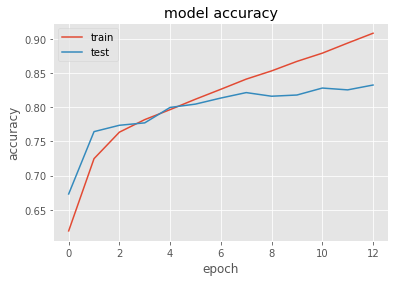

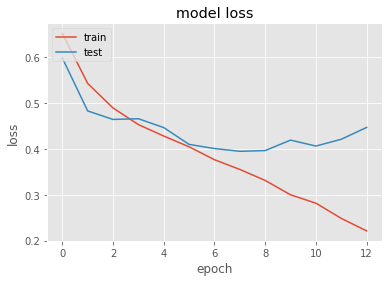

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

71/71 [==============================] - 0s 4ms/step


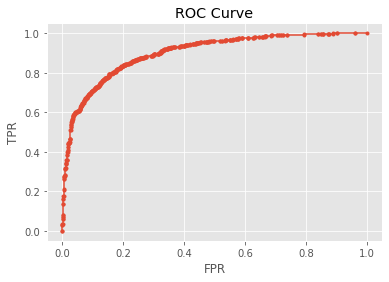

0.9005888406820705


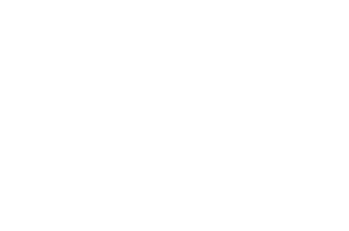

In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred = model.predict(X_test).ravel()

nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)
plt.title('ROC Curve')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()
plt.axis('off')


print(auc_keras)

71/71 [==============================] - 0s 4ms/step


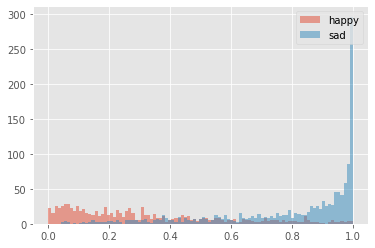

In [ ]:
from matplotlib import pyplot
predict_x=model.predict(X_test) 

happy_index = np.where(y_test.reshape(-1) == 0.)
happy = predict_x[happy_index]

sad_index = np.where(y_test.reshape(-1) == 1.)
sad = predict_x[sad_index]



bins = np.linspace(0, 1, 100)

pyplot.hist(happy, bins, alpha=0.5, label='happy')
pyplot.hist(sad, bins, alpha=0.5, label='sad')
pyplot.legend(loc='upper right')
pyplot.show()

In [ ]:
len(happy)


935

In [ ]:
len(sad)

1325

In [ ]:
for X,Y in zip(predict_x,y_test):
    print("Model Score:", X, "actual score:", Y) 

Model Score: [0.48109117] actual score: [1.]
Model Score: [0.9785953] actual score: [1.]
Model Score: [0.2250881] actual score: [0.]
Model Score: [0.88119906] actual score: [1.]
Model Score: [0.3858003] actual score: [0.]
Model Score: [0.9979747] actual score: [1.]
Model Score: [0.74641716] actual score: [1.]
Model Score: [0.9862715] actual score: [1.]
Model Score: [0.47547635] actual score: [1.]
Model Score: [0.7611458] actual score: [1.]
Model Score: [0.9979062] actual score: [1.]
Model Score: [0.7169462] actual score: [0.]
Model Score: [0.500664] actual score: [0.]
Model Score: [0.64085025] actual score: [1.]
Model Score: [0.66231734] actual score: [0.]
Model Score: [0.23679376] actual score: [0.]
Model Score: [0.9970162] actual score: [1.]
Model Score: [0.28065094] actual score: [0.]
Model Score: [0.77380294] actual score: [1.]
Model Score: [0.8266225] actual score: [1.]
Model Score: [0.45107475] actual score: [1.]
Model Score: [0.29066265] actual score: [0.]
Model Score: [0.981877